In [ ]:
import tetrapolyscope as ps
import interactive_polyscope
from IPython.display import Image, display, HTML

%gui polyscope

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.1 Metal - 88.1


In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

In [4]:
from TetriumColor.Observer import Observer, Cone, Neugebauer, InkGamut, CellNeugebauer, Pigment, Spectra, Illuminant, InkLibrary, load_neugebauer
import TetriumColor.Visualization as viz
from TetriumColor import ColorSpace, ColorSpaceType, PolyscopeDisplayType

objc[33804]: Class GLFWWindowDelegate is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/polyscope_bindings.cpython-311-darwin.so (0x1206be720) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/open3d/cpu/pybind.cpython-311-darwin.so (0x343406db0). One of the two will be used. Which one is undefined.
objc[33804]: Class GLFWApplicationDelegate is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/polyscope_bindings.cpython-311-darwin.so (0x1206be6f8) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/open3d/cpu/pybind.cpython-311-darwin.so (0x343406e28). One of the two will be used. Which one is undefined.
objc[33804]: Class GLFWContentView is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/polyscope_bindings.cpython-311-darwin.so (0x1206be770) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
screenshot_count = 0
! mkdir -p screenshots
def save_ps_screenshot():
    global screenshot_count
    ps.show()  # renders window
    fname = f"screenshots/screenshot_{screenshot_count}.png"
    ps.screenshot(fname)
    # Display in notebook
    display(Image(filename=fname, width=400)) # need to use this for pdf export
    # display(HTML(f'<img src="screenshot_{screenshot_count}.png" style="width:50%;">'))

    screenshot_count += 1

In [7]:
def save_top_inks_as_csv(top_volumes, filename):
    import csv

    # Save top_volumes_all_fp_inks to a CSV file
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Volume", "Ink Combination"])  # Header
        for volume, inks in top_volumes:
            writer.writerow([volume, ", ".join(inks)])  # Write volume and ink combination

def load_top_inks(filename):
    top_volumes = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            volume = float(row[0])
            inks = row[1].split(", ")
            top_volumes.append((volume, inks))
    return top_volumes

In [8]:
from colorsys import rgb_to_hsv
import math

def plot_inks_by_hue(ink_dataset, wavelengths):
    """
    Plots the inks in the dataset sorted by hue.

    Parameters:
    - ink_dataset: dict, a dictionary of ink names and their corresponding Spectra objects.
    - wavelengths: numpy.ndarray, array of wavelengths corresponding to the spectra data.
    """
    # Convert RGB to HSV and sort by hue
    def get_hue(spectra):
        r, g, b = spectra.to_rgb()
        h, _, _ = rgb_to_hsv(r, g, b)
        return h

    # Sort inks by hue
    sorted_inks = sorted(ink_dataset.items(), key=lambda item: get_hue(item[1]))

    # Plot sorted inks row by row by hue
    num_inks = len(sorted_inks)
    cols = math.ceil(math.sqrt(num_inks))
    rows = math.ceil(num_inks / cols)

    plt.figure(figsize=(15, 15))

    for idx, (name, spectra) in enumerate(sorted_inks):
        plt.subplot(rows, cols, idx + 1)
        plt.plot(wavelengths, spectra.data, c=spectra.to_rgb())
        plt.title(name[:10], fontsize=8)  # Show only the first 10 characters of the name
        plt.xlabel("Wavelength (nm)", fontsize=6)
        plt.ylabel("Reflectance", fontsize=6)
        plt.grid(True)
        plt.xlim(wavelengths[0], wavelengths[-1])
        plt.ylim(0, 1)
        plt.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.show()


def show_top_k_combinations(top_volumes, inkset,  k=10):
    """
    Displays the top k ink combinations with their volumes.
    
    Parameters:
    - top_volumes: list of tuples (volume, [ink names])
    - k: number of top combinations to display
    """
    # Plot the spectra of the top inks for the first k entries
    plt.figure(figsize=(10, 10))

    for idx, (volume, ink_names) in enumerate(top_volumes[:k]):
        plt.subplot(math.ceil(k / 4), 4, idx + 1)  # Create a subplot for each entry
        for ink_name in ink_names:  # Plot the spectra of the first 4 inks
            spectra = inkset[ink_name]
            plt.plot(wavelengths, spectra.data, label=ink_name[:10], c=spectra.to_rgb())  # Show only the first 10 characters of the name
        plt.title(f"Volume: {volume:.2e}", fontsize=10)
        plt.xlabel("Wavelength (nm)", fontsize=8)
        plt.ylabel("Reflectance", fontsize=8)
        plt.grid(True)
        plt.xlim(wavelengths[0], wavelengths[-1])
        plt.ylim(0, 1)
        plt.legend(fontsize=6)
        plt.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.show()


### Load FP Inkset

In [9]:
 ### Analyze our 100 ink gamut ###
    # Load the CSV data
data_path = "../../data/fp_inks/all_inks.csv"
df = pd.read_csv(data_path)

spectras = df.iloc[:, 1:].to_numpy()  # Extract reflectance data
wavelengths = np.arange(400, 701, 10)  # Wavelengths from 400 to 700 nm in steps of 10 nm
# Create Spectra objects for each ink
all_fp_inks = {}
for i in range(spectras.shape[0]):
    name = "".join([str(df.iloc[i, j]) for j in range(1)])
    all_fp_inks[name] = Spectra(data=spectras[i], wavelengths=wavelengths)

fp_paper = all_fp_inks.popitem()[1]  # last

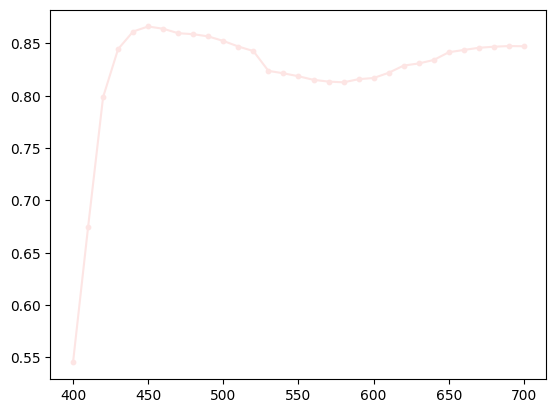

In [10]:
fp_paper.plot()

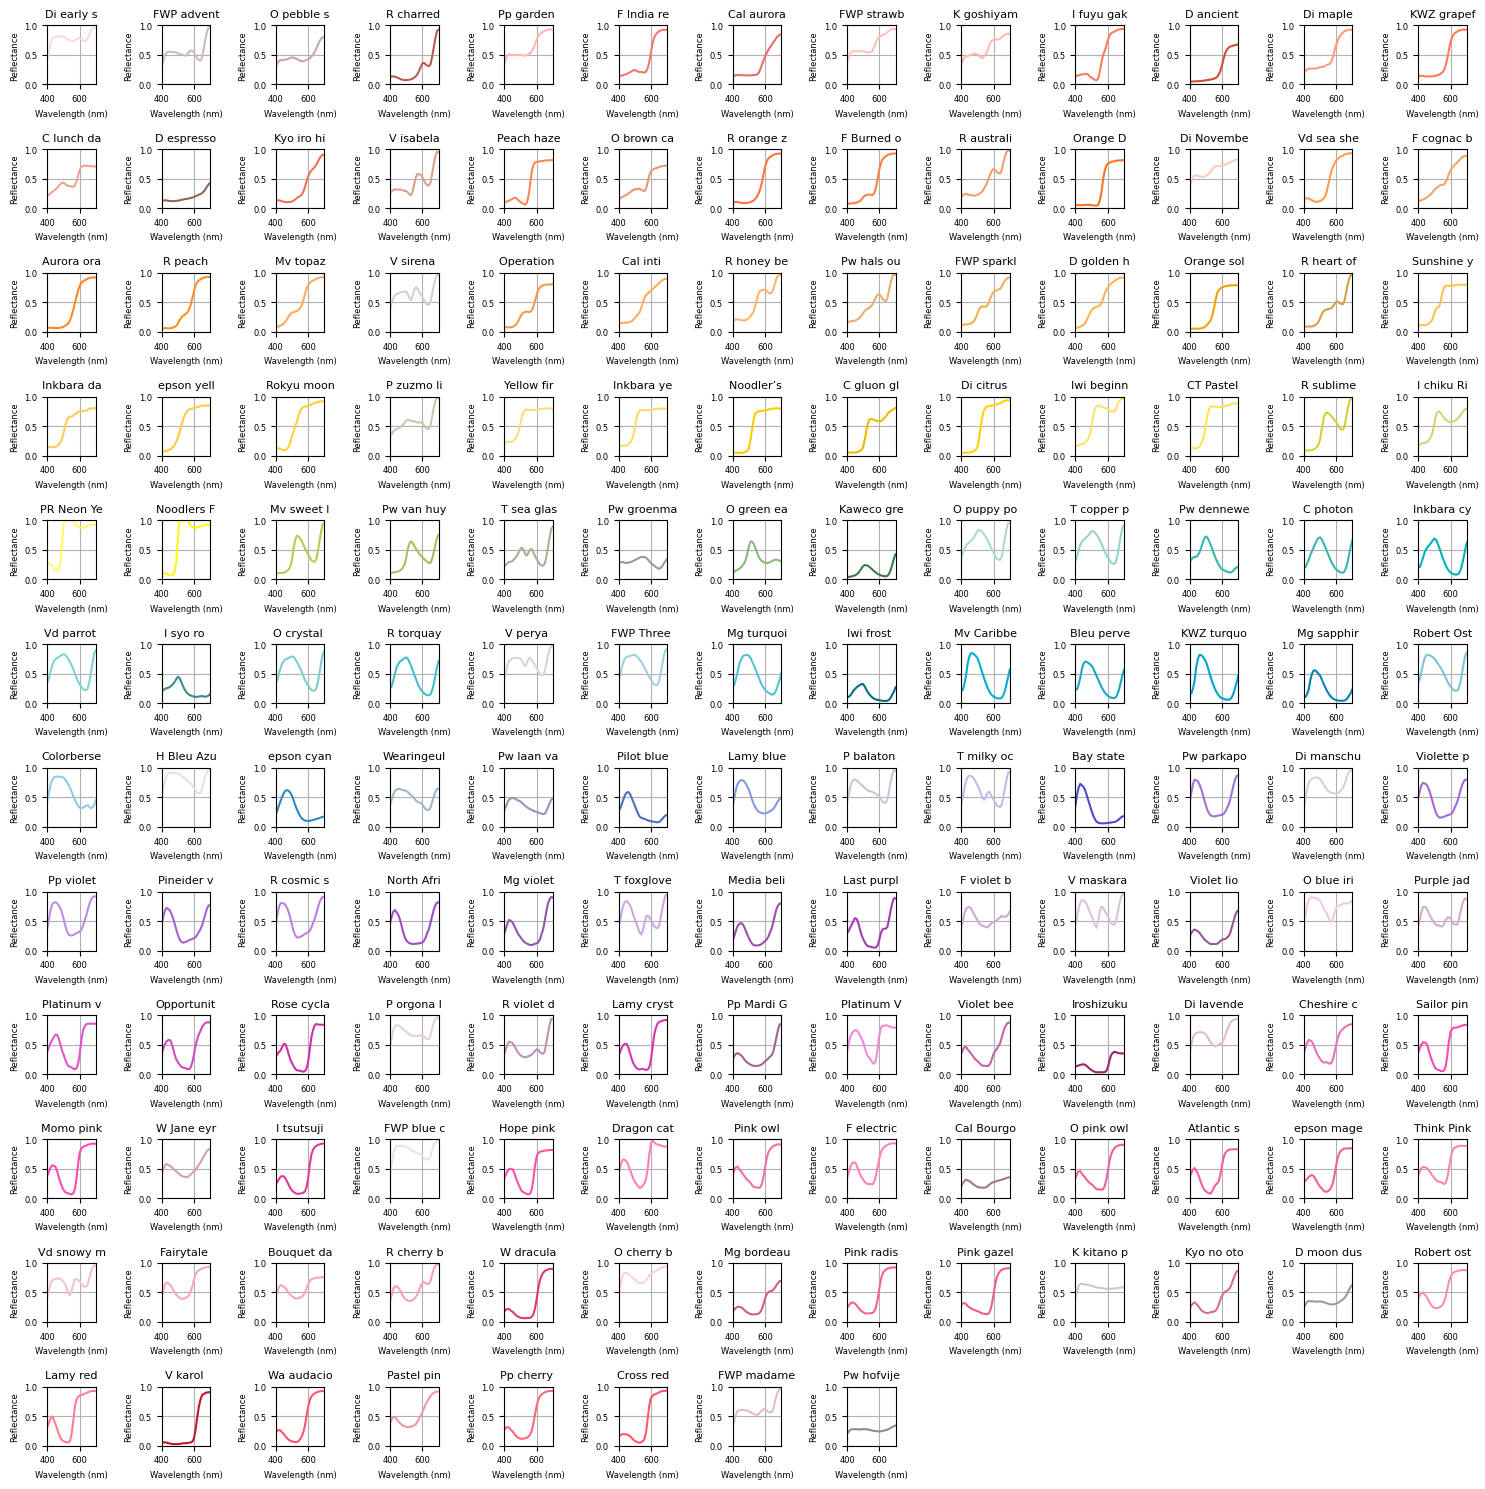

In [11]:
plot_inks_by_hue(all_fp_inks, wavelengths)

### Load Ansari Printer Inkset

In [12]:
data_path = "../../data/ansari/combined_ink_library.csv"
df = pd.read_csv(data_path)

spectras = df.iloc[:, 5:].to_numpy()  # Extract reflectance data
wavelengths = np.arange(400, 701, 10)  # Wavelengths from 400 to 700 nm in steps of 10 nm

# Create Spectra objects for each ink
all_printer_inks = {}
for i in range(spectras.shape[0]):
    name = "".join([str(df.iloc[i, j]) for j in range(3)])
    all_printer_inks[name] = Spectra(data=spectras[i], wavelengths=wavelengths)

ansari_paper = all_printer_inks.popitem()[1]  # last ink is the paper?

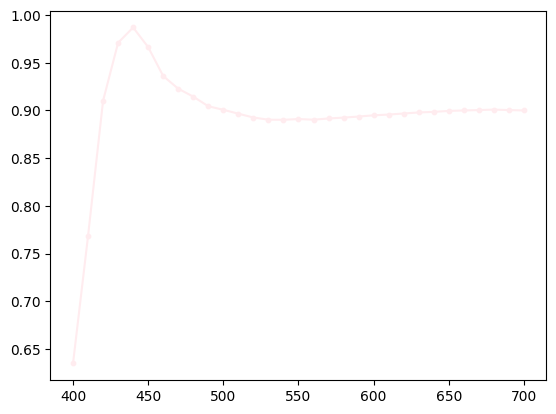

In [13]:
ansari_paper.plot()

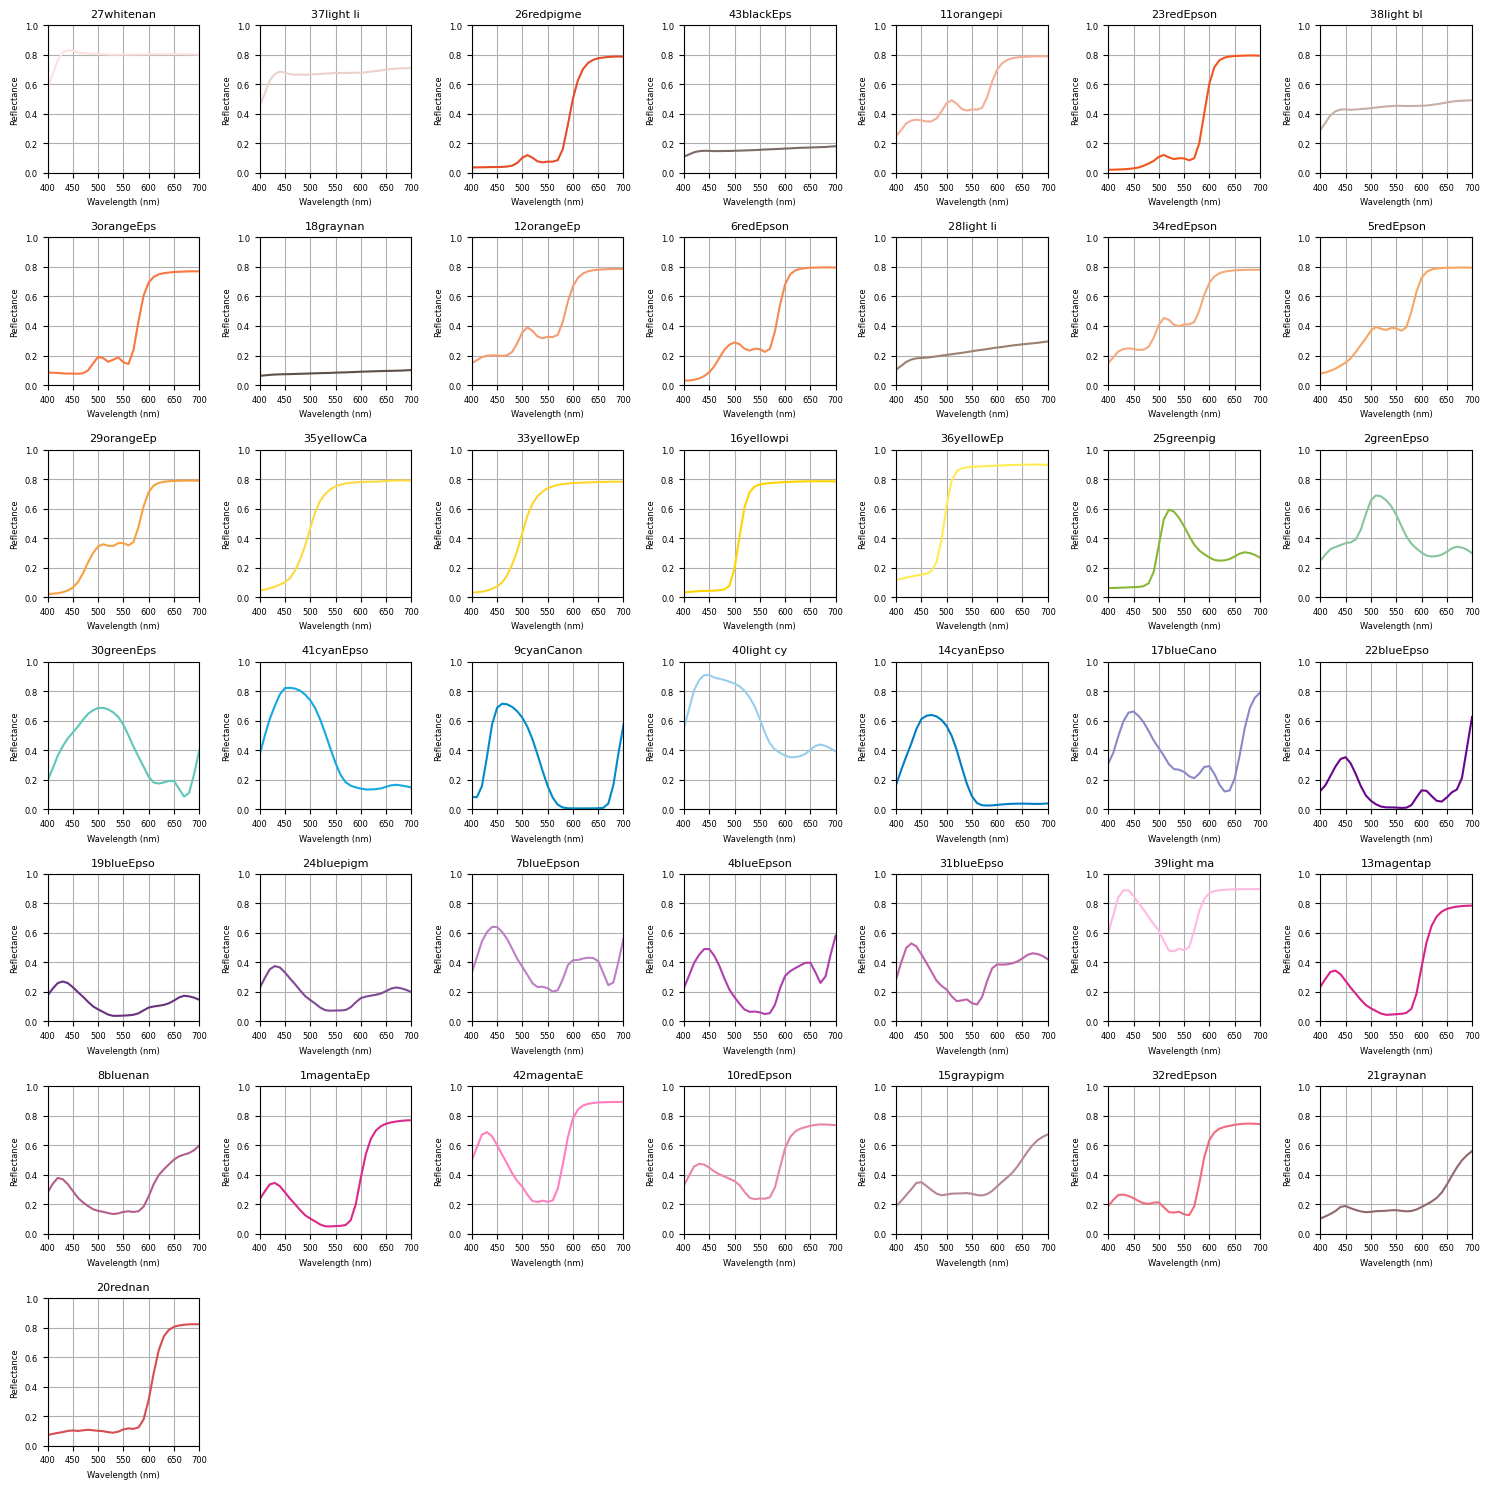

In [14]:
plot_inks_by_hue(all_printer_inks, wavelengths)

## Observer analysis (tetrachromat)

In [15]:
# Define observer and illuminant
d65 = Illuminant.get("d65")
tetrachromat = Observer.tetrachromat(illuminant=d65, wavelengths=wavelengths)

In [16]:
 # Initialize the ink library|
fp_library = InkLibrary(all_fp_inks, fp_paper)

In [17]:
# Perform convex hull search
# top_volumes_all_fp_inks = fp_library.convex_hull_search(tetrachromat, d65)
# save_top_inks_as_csv(top_volumes_all_fp_inks, "top_volumes_all_fp_inks.csv")

top_volumes_all_fp_inks = load_top_inks("./ink-combos/top_ink_combinations_ours.csv")


In [18]:
# top_volumes_6_all_fp_inks = fp_library.cached_pca_search(tetrachromat, d65, k=5)
# save_top_inks_as_csv(top_volumes_6_all_fp_inks, "./ink-combos/top_volumes_6_all_fp_inks.csv")
top_volumes_6_all_fp_inks = load_top_inks("./ink-combos/top_volumes_6_all_fp_inks.csv")

FileNotFoundError: [Errno 2] No such file or directory: './ink-combos/top_volumes_6_all_fp_inks.csv'

In [32]:
#  # Initialize the ink library
ansari_library = InkLibrary(all_printer_inks, ansari_paper)
# # Perform convex hull search
# top_volumes_all_ansari_inks = ansari_library.convex_hull_search(tetrachromat, d65, k=4)
# save_top_inks_as_csv(top_volumes_all_ansari_inks, "./ink-combos/top_volumes_k4_all_ansari_inks.csv")

# show_top_k_combinations(top_volumes_all_ansari_inks, all_fp_inks, k=16)
top_k4_ansari_inks = load_top_inks("./ink-combos/top_volumes_k4_all_ansari_inks.csv")
top_k6_ansari_inks = load_top_inks("./ink-combos/top_volumes_k6_all_ansari_inks.csv")

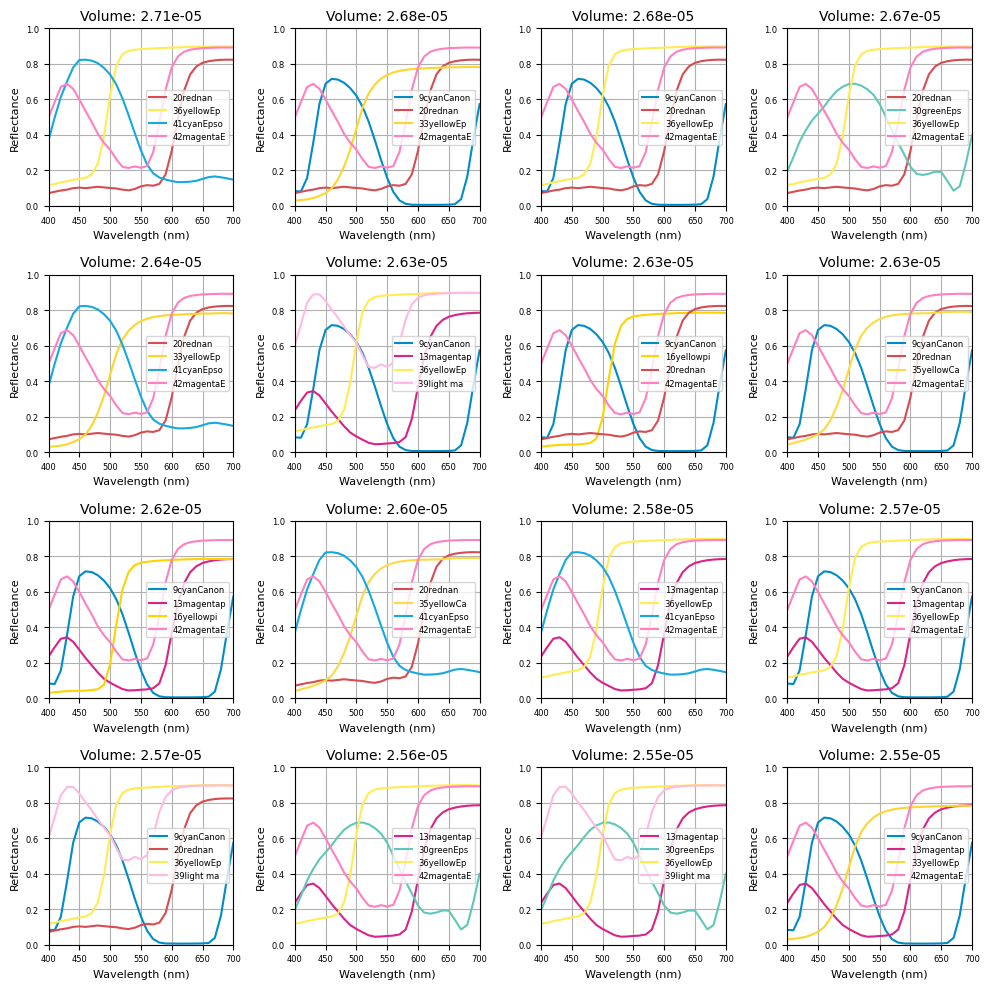

In [33]:
show_top_k_combinations(top_k4_ansari_inks, all_printer_inks, k=16)

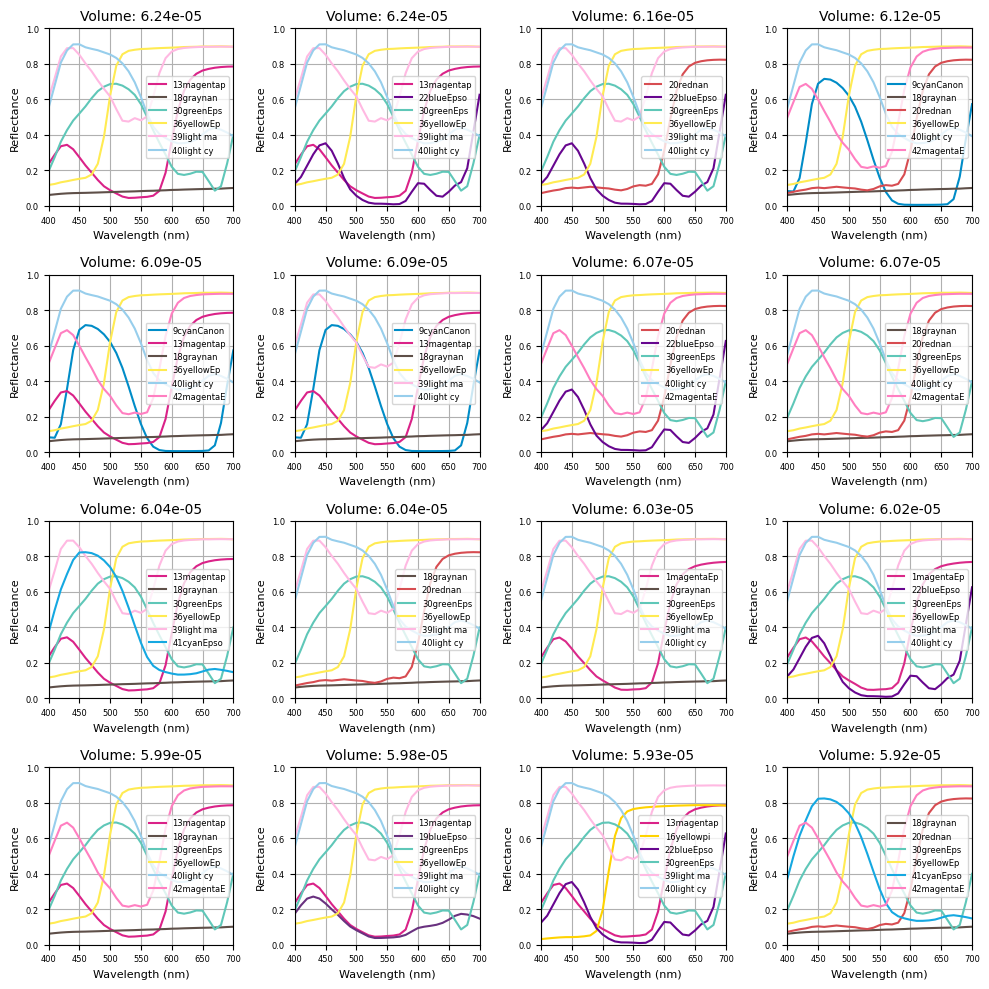

In [29]:
show_top_k_combinations(top_k6_ansari_inks, all_printer_inks, k=16)

In [35]:
best4_fp = [all_fp_inks[ink_name] for ink_name in top_volumes_all_fp_inks[0][1]]
best4_ansari = [all_printer_inks[ink_name] for ink_name in top_k4_ansari_inks[0][1]]
best6_ansari = [all_printer_inks[ink_name] for ink_name in top_k6_ansari_inks[0][1]]

In [36]:
fp_gamut = InkGamut(best4_fp, fp_paper, d65)
fp_point_cloud, fp_percentages = fp_gamut.get_point_cloud(tetrachromat)

ansari_gamut_k4 = InkGamut(best4_ansari, ansari_paper, d65)
ansari_point_cloud_k4, ansari_percentages_k4 = ansari_gamut_k4.get_point_cloud(tetrachromat)

ansari_gamut_k6 = InkGamut(best6_ansari, ansari_paper, d65)
ansari_point_cloud_k6, ansari_percentages_k6 = ansari_gamut_k6.get_point_cloud(tetrachromat)


Generating point cloud: 1it [00:00, 15.71it/s]
Generating point cloud: 1it [00:00, 39.60it/s]
Generating point cloud: 18it [00:06,  2.85it/s]                        


In [37]:
cs = ColorSpace(tetrachromat)

In [42]:
all_ansari_inks_as_points = tetrachromat.observe_spectras(all_printer_inks.values())
all_ansari_inks_point_cloud = cs.convert(all_ansari_inks_as_points, ColorSpaceType.CONE, ColorSpaceType.HERING)[:, 1:]
all_ansari_inks_srgbs = cs.convert(all_ansari_inks_as_points, ColorSpaceType.CONE, ColorSpaceType.SRGB)


all_fp_inks_as_points = tetrachromat.observe_spectras(all_fp_inks.values())
all_fp_inks_point_cloud = cs.convert(all_fp_inks_as_points, ColorSpaceType.CONE, ColorSpaceType.HERING)[:, 1:]
all_fp_inks_srgbs = cs.convert(all_fp_inks_as_points, ColorSpaceType.CONE, ColorSpaceType.SRGB)

In [43]:
ps.init()
ps.set_always_redraw(False)
ps.set_ground_plane_mode('shadow_only')
ps.set_SSAA_factor(2)
ps.set_window_size(720, 720)
factor = 0.1575  # 0.1/5.25
viz.ps.set_background_color((factor, factor, factor, 1))

viz.RenderOBS("observer", cs, PolyscopeDisplayType.HERING_MAXBASIS, num_samples=1000)
viz.ps.get_surface_mesh("observer").set_transparency(0.3)
viz.RenderPointCloud("ansari_points", cs.convert(ansari_point_cloud_k4, ColorSpaceType.CONE, ColorSpaceType.HERING)[:, 1:], mode="sphere")
# viz.RenderMeshFromNonConvexPointCloud("ansari_gamut_k4", cs.convert(ansari_point_cloud_k4, ColorSpaceType.CONE, ColorSpaceType.HERING)[:, 1:])
viz.RenderPointCloud("all_ansari_inks", all_ansari_inks_point_cloud, all_ansari_inks_srgbs)
viz.RenderPointCloud("all_fp_inks", all_fp_inks_point_cloud, all_fp_inks_srgbs)
viz.RenderMetamericDirection("meta_dir", tetrachromat, PolyscopeDisplayType.HERING_MAXBASIS, 2,
                                 np.array([0, 0, 0]), radius=0.005, scale=1.2)
viz.ps.show()

Loaded full colors from cache: full_colors_dd642fe82a2a85365fec867dffd5caac_1000.pkl


RAYCAST_SPHERE
SPHERE_PROPAGATE_COLOR
SHADE_COLOR
LIGHT_MATCAP
RAYCAST_SPHERE
SPHERE_PROPAGATE_COLOR
SHADE_COLOR
LIGHT_MATCAP


In [ ]:
ps.init()
ps.set_always_redraw(False)
ps.set_ground_plane_mode('shadow_only')
ps.set_SSAA_factor(2)
ps.set_window_size(720, 720)
factor = 0.1575  # 0.1/5.25
viz.ps.set_background_color((factor, factor, factor, 1))

viz.RenderOBS("observer", cs, PolyscopeDisplayType.HERING_MAXBASIS, num_samples=1000)
viz.RenderPointCloud("fp_points", cs.convert(fp_point_cloud, ColorSpaceType.CONE, ColorSpaceType.HERING)[:, 1:])
viz.RenderPointCloud("all_fps", all_inks_point_cloud, all_inks_srgbs)
viz.RenderMetamericDirection("meta_dir", tetrachromat, PolyscopeDisplayType.HERING_MAXBASIS, 2,
                                 np.array([0, 0, 0]), radius=0.005, scale=1.2)
viz.ps.show()

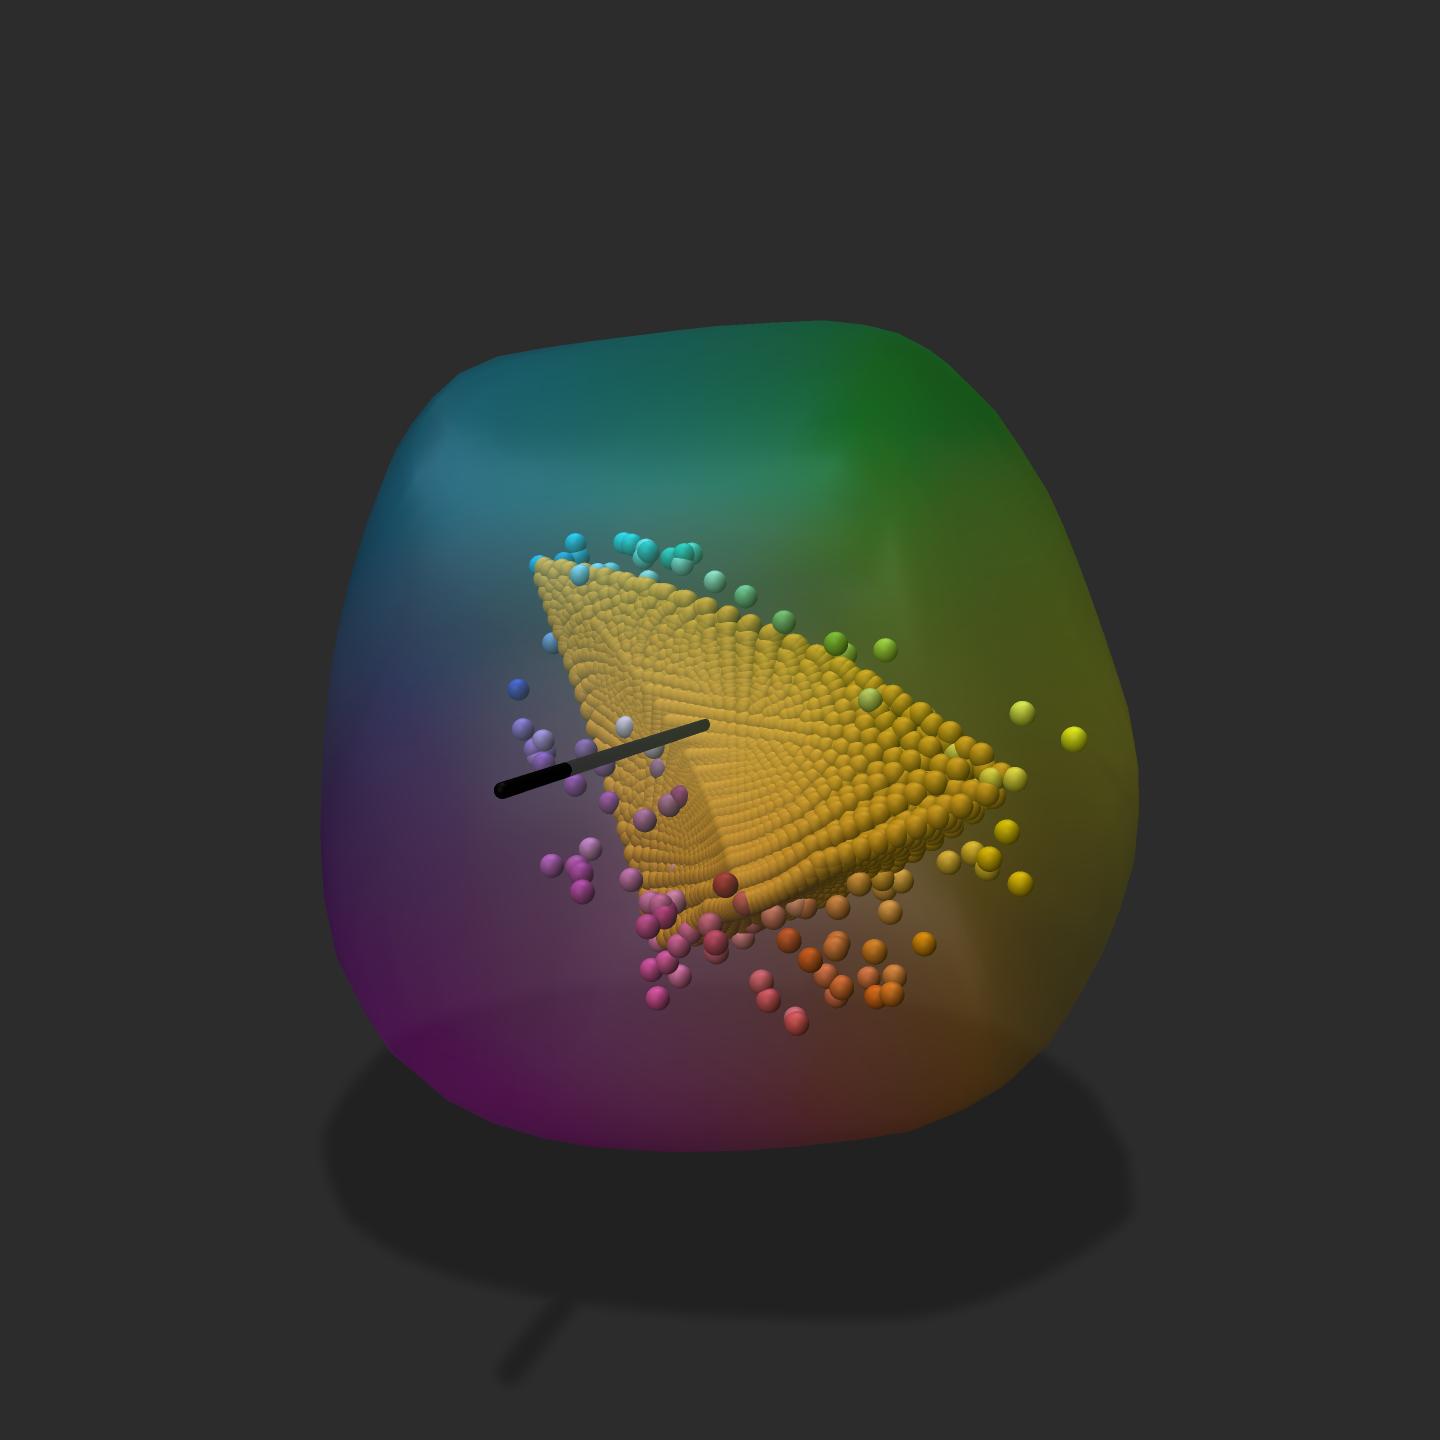

In [ ]:
save_ps_screenshot() # all possible inks + the best printer gamut (which would become completely stable)

In [ ]:
save_ps_screenshot()

In [ ]:
save_ps_screenshot()